  0%|          | 0/60 [00:00<?, ?it/s]

Fitting a Bazin Function


10519it [01:17, 135.99it/s, +500 | bound: 176 | nc: 1 | ncall: 150039 | eff(%):  7.369 | loglstar:   -inf < -94.335 <    inf | logz: -114.665 +/-    nan | dlogz:  0.001 >  0.509]


AttributeError: 'Results' object has no attribute 'flatten'

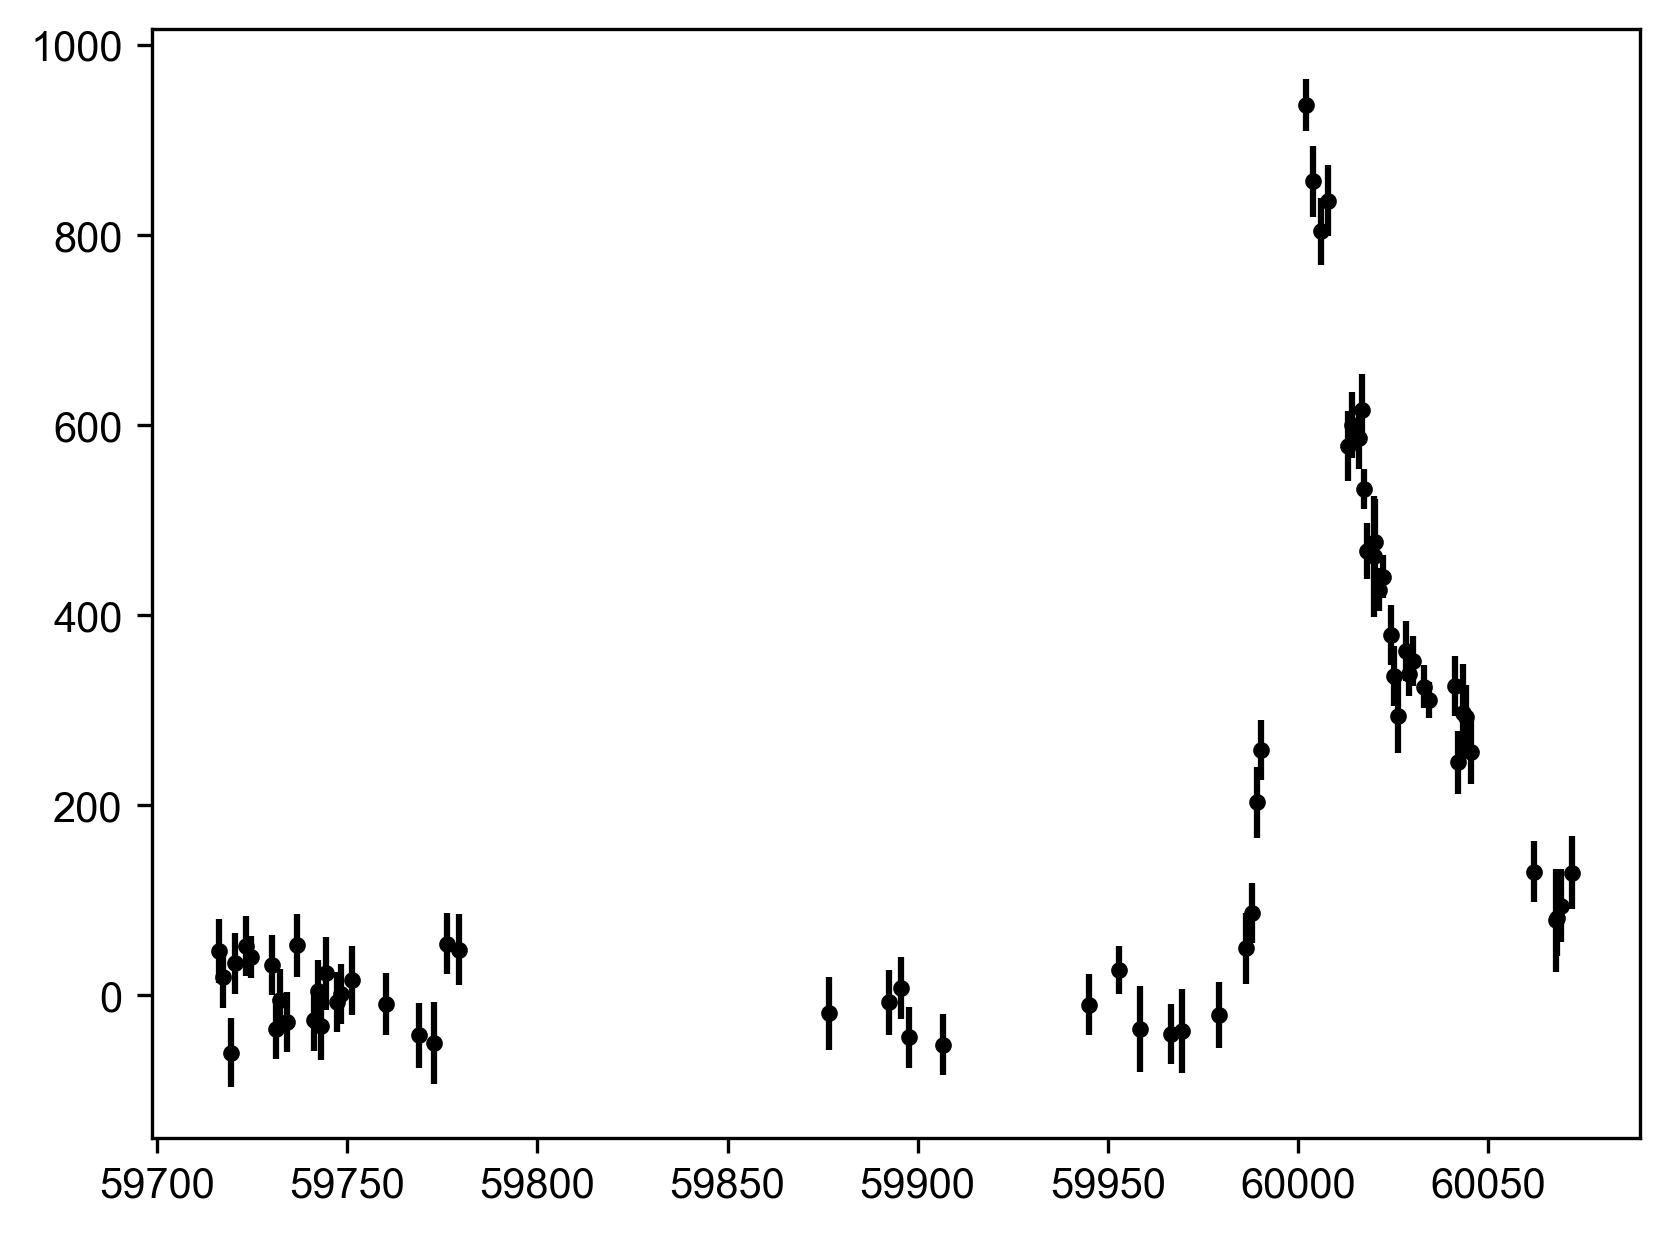

In [25]:
import sys
import importlib
from importlib import reload
import os
import math
import glob
import astropy
from astropy.io import fits
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt
import time
import scipy as sp
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import curve_fit
import multiprocessing
import gc
from tqdm import *
import matplotlib
import matplotlib.pyplot as plt
from emcee.autocorr import AutocorrError, function_1d
import yaml
from multiprocessing import Pool
from schwimmbad import MPIPool
import logging
import warnings
from pathlib import Path

import numpy as np
import dynesty
from dynesty import NestedSampler
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot


global data


def def_global(x, y, y_err):
    data = np.array([x, y, y_err]).astype("float64")


def Lambobstorest(lambda_obs, Z):
    lambda_rest = np.divide(lambda_obs, (1.0 + Z))
    return lambda_rest


def Lambresttoobs(lambda_rest, Z):
    lambda_obs = np.multiply(lambda_rest, (1.0 + Z))
    return lambda_obs


def bazin(theta):
    A, B, T_rise, T_fall, t0 = theta
    quoitent = A * np.exp(-(x_global - t0) / T_fall)
    divisor = 1 + np.exp(-(x_global - t0) / T_rise)
    constant = B
    return (quoitent / divisor) + constant


def bazin_no_global(x,theta):
    A, B, T_rise, T_fall, t0 = theta
    quoitent = A * np.exp(-(x_global - t0) / T_fall)
    divisor = 1 + np.exp(-(x_global - t0) / T_rise)
    constant = B
    return (quoitent / divisor) + constant

def baz_tmax(t0, T_rise, T_fall):
    return t0 + T_rise * np.log((T_fall / T_rise) - 1)


def rise_mjd_fit(t, a, T_exp_pow, n):
    y = np.where(t <= T_exp_pow, 0, a * (t - T_exp_pow) ** n)
    return y


def chisq_bazin(p):
    A, B, T_rise, T_fall, t0 = p
    return np.sum(
        ((y_global - (bazin(p))) / y_err_global) ** 2
    )


def lnpriorline_bazin(p):
    A, B, T_rise, T_fall, t0 = p
    if (
        0 < A < 1e5
        and -5 < B < +5
        and 0 < T_rise < 300
        and 0 < T_fall < 300
        and 0 < t0
        and T_rise < T_fall
    ):
        return 0.0
    return -np.inf


def lnlikeline_bazin(p):
    chisq = chisq_bazin(p)
    return -0.5 * chisq


def lnprobline_bazin(p):
    lp = lnpriorline_bazin(p)
    if math.isnan(lp):
        return -np.inf
    if not np.isfinite(lp):
        return -np.inf
    ln_like = lnlikeline_bazin(p)
    if math.isnan(ln_like):
        return -np.inf
    return lp + ln_like


# Doing the same treatment for the fireball model
#  Inputs  = t, a, T_exp_pow, n
def chisq_fireball(p):
    a, T_exp_pow, n = p[0], p[1], p[2]
    return np.sum(
        ((y_global - (rise_mjd_fit(x_global, a, T_exp_pow, n))) / y_err_global) ** 2
    )


def lnpriorline_fireball(p):
    a, T_exp_pow, n = p
    if (
        1 < a < 0.4 * np.max(y_global)
        and 0.5 < n < 4.0
        and T_exp_pow > np.min(x_global)
        and T_exp_pow < np.max(x_global)
    ):
        return 0
    return -np.inf


def lnlikeline_fireball(p):
    chisq = chisq_fireball(p)
    return -0.5 * chisq


def lnprobline_fireball(p):
    lp = lnpriorline_fireball(p)
    if not np.isfinite(lp):
        return -np.inf
    ln_like = +lnlikeline_fireball(p)
    if math.isnan(ln_like):
        return -np.inf
    return lp + ln_like


def baz_tmax(t0, T_rise, T_fall):
    return t0 + T_rise * np.log((T_fall / T_rise) - 1)


def baz_tmax(t0, T_rise, T_fall):
    return t0 + T_rise * np.log((T_fall / (T_rise) - 1))


# def rise_mjd_fit(t, a, T_exp_pow, n):
#    y = np.where(t <= T_exp_pow, 0, a * (t - T_exp_pow) ** n)
#    return y


def AB_mag_err(flux, dflux):
    mag_err = 2.5 / np.log(10.0) * abs(dflux) / abs(flux)
    return mag_err


def flux_to_ABmag(flux):
    mag = 2.5 * (23 - np.log10(float(flux) * 1e-6)) - 48.6
    return mag


def fit_bazin(**kwargs):
    global x_global
    global y_global
    global y_err_global
    print("Fitting a Bazin Function")
    priors = kwargs.get("priors", [0.1 * np.max(y_global), 0, 3, 4, np.mean(x_global)])
    # priors = np.array(priors)
    nwalkers = kwargs.get("nwalkers", int(100))
    nsteps = kwargs.get("nsteps", int(500))
    progress = kwargs.get("progress", True)
    plot = kwargs.get("plot", False)
    object = kwargs.get("object", "")

    ndim = 5
    nwalkers, ndim = int(nwalkers), int(5)
    nsteps = int(nsteps)
    # pos = priors + 1 * np.random.randn(nwalkers, ndim)
    # A, B, T_rise, T_fall, t0

    pos = np.zeros((nwalkers, ndim))
    pos1 = float(priors[0]) + 10 * np.random.randn(nwalkers)
    pos2 = float(priors[1]) + 1 * np.random.randn(nwalkers)
    pos3 = float(priors[2]) + 2 * np.random.randn(nwalkers)
    pos4 = float(priors[3]) + 2 * np.random.randn(nwalkers)
    pos5 = float(priors[4]) + 5 * np.random.randn(nwalkers)
    pos = [pos1, pos2, pos3, pos4, pos5]
    pos = np.transpose(pos)

    # sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobline_bazin)
    # sampler.run_mcmc(pos, nsteps, progress=progress)

    # with MPIPool() as pool:
    #     # with Pool() as pool:
    #     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobline_bazin, pool=pool)
    #     sampler.run_mcmc(pos, nsteps, progress=True)

    # samples = sampler.get_chain()
    # flat_samples = sampler.get_chain(
    #     discard=int(nsteps * 0.4), flat=True, thin=int(nsteps * 0.01)
    # )


    # NESTED SAMPLING 

    # 'A', 'B', 'T_rise', 'T_fall', and 't0'

    bounds = [(0, np.max(y_global)), (-10, 10), (0, 50), (0, 50), (np.min(x_global), np.max(x_global))] # bounds on each parameter

    def prior_transform(u):
        theta1 = bounds[0][1] * (u[0]) 
        theta2 = (u[1] - 0.5) * 2 * bounds[1][1] 
        theta3 = u[2] * bounds[2][1] 
        theta4 = u[3] * bounds[3][1] 
        theta5 = (u[4] * (bounds[4][1] - bounds[4][0])) + bounds[4][0]  # transform from [0, 1] to [0, 0.5]
        return np.array([theta1, theta2,theta3,theta4,theta5])

    # Set up the nested sampler
    sampler = NestedSampler(lnlikeline_bazin, prior_transform=prior_transform, ndim=ndim, bound='multi')

    # Run the nested sampling algorithm
    sampler.run_nested()

    # Get the results
    results = sampler.results

    print(sampler.results.flatten())

    best_params = np.zeros(ndim)
    lower_quartile = np.zeros(ndim)
    upper_quartile = np.zeros(ndim)
    for i in range(ndim):
        best_params[i] = np.percentile(results.samples[:, i], [50])
        lower_quartile[i] = np.percentile(results.samples[:, i], [16])
        upper_quartile[i] = np.percentile(results.samples[:, i], [84])
    
    A, B, T_rise, T_fall, t0 = best_params
    best_t_max = baz_tmax(t0, T_rise, T_fall)
    best_bazin_max_flux =bazin_no_global(t, A, B, T_rise, T_fall, t0)


    if plot == True:
        labels = ["A", "B", "T_rise", "T_fall", "t0"]

        plt.figure(dpi=300)
        fig = corner.corner(
            results.samples,
            labels=labels,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs={"fontsize": 12},
        )
        plt.savefig(output_dir + "/corner/" + object + "_bazin_corner_plot.png")

        plt.figure(dpi=200)
        fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
        labels = labels
        for i in range(ndim):
            ax = axes[i]
            ax.plot(results.samples[:, i], "k", alpha=0.01)
            ax.set_xlim(0, len(results.samples))
            ax.set_ylabel(labels[i - 1])
            ax.yaxis.set_label_coords(-0.1, 0.5)


        axes[-1].set_xlabel("step number")
        plt.savefig(output_dir + "/scatter/" + object + "_bazin_scatter.png")
        plt.close()

        
        print(
            "Using the Bazin fit to calculate t-1/2 and t+1/2 from the bazin fits"
        )

        # setting max and min for outputplot
        t_minus_five, t_plus_five = None, None
        x_range = np.linspace(np.min(x_global), np.max(x_global), 1000)
        for x in x_range:
            if t_min_plot == None:
                if (
                    bazin_no_global(x, A, B, T_rise, T_fall, t0)
                    > 0.05 * best_bazin_max_flux
                ):
                    t_minus_five = x
            if t_plus_five == None and (x > best_t_max):
                if (
                    bazin_no_global(t, A, B, T_rise, T_fall, t0)
                    < 0.05 * best_bazin_max_flux
                ):
                    t_plus_five = x

        print(
            "Using the Bazin fit to calculate t-1/2 and t+1/2 from the bazin fits"
        )

                # setting max and min for outputplot
        t_minus_five, t_plus_five = None, None
        x_range = np.linspace(np.min(x_global), np.max(x_global), 1000)
        for sample in samples.re:
            for x in x_range:
                if t_min_plot == None:
                    if (
                        bazin_no_global(x, A, B, T_rise, T_fall, t0)
                        > 0.05 * best_bazin_max_flux
                    ):
                        t_minus_five = x
                if t_plus_five == None and (x > best_t_max):
                    if (
                        bazin_no_global(t, A, B, T_rise, T_fall, t0)
                        < 0.05 * best_bazin_max_flux
                    ):
                        t_plus_five = x

            print(
                "Using the Bazin fit to calculate t-1/2 and t+1/2 from the bazin fits"
            )

        return results


    A = samples[:, 0]
    B = samples[:, 1]
    T_rise = samples[:, 2]
    T_fall = samples[:, 3]
    t0 = samples[:, 4]

    t_max_samples = baz_tmax(t0, T_rise, T_fall)
    theta = [A, B, T_rise, T_fall, t0]
    print((theta))
    print((t_max_samples))
    flux_max_samples = bazin_no_global(t_max_samples, theta)

    time_max_mcmc = np.nanmean(t_max_samples)
    time_max_mcmc_err = np.nanstd(t_max_samples)

    best_params = np.zeros(ndim)
    lower_quartile = np.zeros(ndim)
    upper_quartile = np.zeros(ndim)

    for i in range(ndim):
        best_params[i] = np.percentile(samples[:, i], [50])
        lower_quartile[i] = np.percentile(samples[:, i], [16])
        upper_quartile[i] = np.percentile(samples[:, i], [84])

    A, B, T_rise, T_fall, t0 = best_params
    A_upper, B_upper, T_rise_upper, T_fall_upper, t0_upper = upper_quartile
    A_lower, B_lower, T_rise_lower, T_fall_lower, t0_lower = lower_quartile

    if plot == True:
        # overplotting on graph
        plt.figure(dpi=300)
        inds = np.random.randint(len(samples), size=100)
        x0 = np.linspace(np.min(x_global), np.max(x_global), 300)
        for ind in inds:
            sample = samples[ind]
            plt.plot(x0, bazin(x0, *sample), "deepskyblue", alpha=0.1)
        plt.plot([], [], color="deepskyblue", alpha=0.9, label="Bazin Evaluations")

        plt.errorbar(
            x_global,
            y_global,
            y_err_global,
            fmt=".",
            color="black",
            capsize=0,
            label="ATLAS o-band",
        )

        plt.ylim(np.min(y_global) * 0.9, np.max(y_global) * 1.1)
        plt.xlim(np.min(x_global) * 0.999, np.max(x_global) * 1.001)

        plt.ylabel(r" Flux Density [$\rm \mu Jy$]")
        plt.xlabel(r"time [mjd]")
        plt.legend(frameon=False)
        plt.vlines(
            bazin_maximum,
            -50,
            np.max(y_global) * 1.3,
            color="gray",
            alpha=0.9,
            linestyle="--",
        )
        plt.vlines(
            time_max_mcmc,
            -50,
            np.max(y_global) * 1.3,
            color="orange",
            alpha=0.9,
            linestyle="--",
        )
        plt.savefig(output_dir + "/overplot/" + object + "_bazin_overplot.png")

    plt.close()
    print("best params", best_params)
    gc.collect()
    return (
        time_max_mcmc,
        time_max_mcmc_err,
        best_params,
        upper_quartile,
        lower_quartile,
        t_max_samples,
        flux_max_samples,
        flat_samples,
    )


def fit_fireball(**kwargs):
    print("Fitting a Fireball Model")

    priors = kwargs.get("priors", [1, np.mean(x_global), 2])
    # print(f'No priors given = assumning {priors}')
    nwalkers = kwargs.get("nwalkers", int(1000))
    nsteps = kwargs.get("nsteps", int(5000))
    progress = kwargs.get("progress", True)
    plot = kwargs.get("plot", False)
    object = kwargs.get("object", "")

    ndim = 3
    nwalkers, ndim = int(nwalkers), int(ndim)
    nsteps = int(int(nsteps))

    #  a, T_exp_pow, n
    pos = np.zeros((nwalkers, ndim))
    pos[:, 0] = float(priors[0]) + 2 * np.random.randn(nwalkers)
    pos[:, 1] = float(priors[1]) + 100 * np.random.randn(nwalkers)
    pos[:, 2] = float(priors[2]) + 0.1 * np.random.randn(nwalkers)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobline_fireball)
    sampler.run_mcmc(pos, nsteps, progress=progress)

    # with MPIPool() as pool:
    #     # with Pool() as pool:
    #     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobline_fireball, pool=pool)
    #     sampler.run_mcmc(pos, nsteps, progress=True)

    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(
        discard=int(nsteps * 0.4), thin=int(nsteps * 0.1), flat=True
    )

    labels = ["A", "b", "c"]
    inds = np.random.randint(len(flat_samples), size=100)

    # Doing a second MCMC for the fireball
    mcmc = np.percentile(flat_samples[:, 1], [16, 50, 84])
    time_explode = mcmc[1]

    if plot == True:
        labels = ["a", "T_explode", "n"]

        plt.figure(dpi=300)
        fig = corner.corner(
            flat_samples,
            labels=labels,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs={"fontsize": 12},
        )
        plt.savefig(output_dir + "/corner/" + object + "_fireball_corner.png")

        plt.figure(dpi=200)
        fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = labels
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.01)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i - 1])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number")
        plt.savefig(output_dir + "/scatter/" + object + "_bazin_scatter.png")
        plt.close()

        # overplotting on graph
        x0 = np.linspace(np.min(x_global), np.max(x_global), 300)
        plt.figure(dpi=300)
        for ind in inds:
            sample = flat_samples[ind]
            plt.plot(x0, rise_mjd_fit(x0, *sample), "mediumorchid", alpha=0.1)
        plt.errorbar(
            lightcurve_data["MJD"],
            lightcurve_data["uJy"],
            yerr=lightcurve_data["duJy"],
            fmt=".k",
            capsize=0,
            label="rising points",
        )
        plt.ylim(-10, np.max(y_global))
        plt.errorbar(x_global, y_global, y_err_global, fmt=".", color="grey", capsize=0)
        plt.plot([], [], color="mediumorchid", alpha=0.9, label="Fireball Evaluations")
        plt.vlines(time_explode, 0, 100, color="k")
        plt.ylabel(r" Flux Density [$\rm \mu Jy$]")
        plt.xlabel(r"time [mjd]")
        plt.legend(frameon=False)
        plt.savefig(output_dir + "/overplot/" + object + "_fireball_overplot.png")

        plt.close()

    best_params = np.zeros(ndim)
    lower_quartile = np.zeros(ndim)
    upper_quartile = np.zeros(ndim)
    for i in range(ndim):
        best_params[i] = np.percentile(flat_samples[:, i], [50])
        lower_quartile[i] = np.percentile(flat_samples[:, i], [16])
        upper_quartile[i] = np.percentile(flat_samples[:, i], [84])

    a, T_exp_pow, n = best_params
    a_upper, T_exp_pow_upper, n_upper = upper_quartile
    a_lower, T_exp_pow_lower, n_lower = lower_quartile
    plt.close()
    plt.close("all")
    gc.collect()
    return best_params, upper_quartile, lower_quartile, flat_samples


if __name__ == "__main__":
    # from multiprocessing import Pool

    warnings.filterwarnings("ignore")  # setting ignore as a parameter

    logging.getLogger().setLevel(logging.ERROR)

    # plt.style.use('ggplot')
    plt.style.use("default")
    plt.rcParams["font.family"] = "Arial"

    # looking for YAML Settings file - if there isn't one we will make it

    my_file = Path("SNIPER_config.yml")
    if my_file.is_file():
        with open("SNIPER_config.yml", "r") as ymlfile:
            cfg = yaml.safe_load(ymlfile)
    else:
        print(
            "SNIPER Settings YAML does not exist - creating file in current working directory"
        )
        d = {
            "data": {
                "data_dir": "Your Data Directory",
                "IAU_Names": "IAU Names csv",
                "output_dir": os.getcwd(),
                "flux_unc_cut": 100,
            },
            "mcmc": {
                "mjd_minus": 300,
                "mjd_plus": 200,
                "nwalkers_bazin": 50,
                "nsteps_bazin": 1e3,
                "nwalkers_fireball": 50,
                "nsteps_fireball": 1e3,
            },
            "progress": {"plots": True, "progress_bar": True},
        }
        with open("SNIPER_config.yml", "w") as yaml_file:
            yaml.dump(d, yaml_file, default_flow_style=False)

    MJD_minus = int(float(cfg["mcmc"]["mjd_minus"]))
    MJD_plus = int(float(cfg["mcmc"]["mjd_plus"]))
    nwalkers_bazin = int(float(cfg["mcmc"]["nwalkers_bazin"]))
    nsteps_bazin = int(float(cfg["mcmc"]["nsteps_bazin"]))
    flux_unc_cut = int(float(cfg["data"]["flux_unc_cut"]))

    nwalkers_fireball = int(float(cfg["mcmc"]["nwalkers_fireball"]))
    nsteps_fireball = int(float(cfg["mcmc"]["nsteps_fireball"]))

    progress = cfg["progress"]["progress_bar"]
    plot = cfg["progress"]["plots"]

    output_dir = cfg["data"]["output_dir"] + "SNIPER_Output"

    # Creating output directories if they do not already exist

    if os.path.isdir(output_dir + "/corner") == False:
        print("No corner plot directory - making one!")
        os.makedirs(output_dir + "/corner/")

    if os.path.isdir(output_dir + "/overplot/") == False:
        print("No overplot plot directory - making one!")
        os.makedirs(output_dir + "/overplot/")

    if os.path.isdir(output_dir + "/scatter/") == False:
        print("No scatter plot directory - making one!")
        os.makedirs(output_dir + "/scatter/")

    if os.path.isdir(output_dir + "/combined_output/") == False:
        print("No combined_output plot directory - making one!")
        os.makedirs(output_dir + "/combined_output/")

    IAU_list = pd.read_csv(cfg["data"]["IAU_Names"], header=None)
    IAU_list.columns = ["IAU_NAME"]
    lc_directory = cfg["data"]["data_dir"]

    SNIPER_OUTPUT = pd.DataFrame()

    for TNS_ID in tqdm(IAU_list["IAU_NAME"], leave=False):
        lightcurve_data = []
        df = []
        t_minus_half_samples, t_plus_half_samples = [], []
        try:
            # t_guess = IAU_list.loc[IAU_list["IAU_NAME"] == TNS_ID, "t_guess"]
            # print(f"Working on {TNS_ID}")
            f = []
            f = lc_directory + TNS_ID + "/" + TNS_ID + ".o.1.00days.lc.txt"
            cols = [
                [
                    "MJD",
                    "m",
                    "dm",
                    "uJy",
                    "duJy",
                    "F",
                    "err",
                    "chi/N",
                    "RA",
                    "Dec",
                    "x",
                    "y",
                    "maj",
                    "min",
                    "phi",
                    "apfit",
                    "mag5sig",
                    "Sky",
                    "Obs",
                    "mask",
                ]
            ]
            df = pd.read_csv(f, delim_whitespace=True)
            df = df.filter(("MJD", "uJy", "duJy"), axis=1)
            df.drop(df[df.duJy > flux_unc_cut].index, inplace=True)
            df = df.dropna()

            time = np.array(df.MJD)
            flux = np.array(df.uJy)

            t_guess = time[np.argmax(savgol_filter(flux, 30, 2))]

            df_cut_min = float(t_guess) - MJD_minus
            df_cut_max = float(t_guess) + MJD_plus
            df_new = df.dropna(how="any", axis=0)

            lightcurve_data = df_new.loc[
                (df["MJD"].astype("float64") >= df_cut_min)
                & (df["MJD"].astype("float64") <= df_cut_max)
            ]
            x_global, y_global, y_err_global = (
                lightcurve_data["MJD"].astype("float64"),
                lightcurve_data["uJy"].astype("float64"),
                lightcurve_data["duJy"].astype("float64"),
            )
            def_global(x_global, y_global, y_err_global)

            fig, ax = plt.subplots(dpi=300)
            ax.errorbar(
                x_global,
                y_global,
                y_err_global,
                color="k",
                linestyle="",
                fmt=".",
            )

            def_global(x_global, y_global, y_err_global)

            bazin_results = fit_bazin(
                progress=progress,
                plot=True,
                object=TNS_ID,
                nwalkers=nwalkers_bazin,
                nsteps=nsteps_bazin,
            )

            A, B, T_rise, T_fall, t0 = bazin_results[2]
            t_max_bazin = np.nanmean(bazin_results[5])
            baz_max_flux = np.nanmean(bazin_results[6])
            x_range = np.linspace(np.min(x_global), np.max(x_global), 500)

            flat_samples_bazin = bazin_results[7]
            inds = np.random.randint(len(flat_samples_bazin), size=100)
            for ind in inds:
                sample = flat_samples_bazin[ind]
                ax.plot(
                    x_range,
                    bazin(x_range, *sample),
                    "cornflowerblue",
                    alpha=0.1,
                )

            # setting max and min for outputplot
            t_min_plot, t_max_plot = None, None
            for time_variable in x_range:
                if t_min_plot == None:
                    if (
                        bazin(time_variable, A, B, T_rise, T_fall, t0)
                        > 0.05 * baz_max_flux
                    ):
                        t_min_plot = time_variable
                if t_max_plot == None and (time_variable > t_max_bazin):
                    if (
                        bazin(time_variable, A, B, T_rise, T_fall, t0)
                        < 0.05 * baz_max_flux
                    ):
                        t_max_plot = time_variable

            print(
                "Using the Bazin fit to calculate t-1/2 and t+1/2 from the bazin fits"
            )

            bazin_range = np.linspace(np.min(x_global), np.max(x_global), 1000)
            for sample in flat_samples_bazin:
                t_minus_half, t_plus_half = None, None
                A, B, T_rise, T_fall, t0 = sample
                for time_variable in bazin_range:
                    if t_minus_half == None:
                        if (
                            bazin(time_variable, A, B, T_rise, T_fall, t0)
                            > 0.5 * baz_max_flux
                        ):
                            t_minus_half = time_variable
                    if t_plus_half == None and (time_variable > t_max_bazin):
                        if (
                            bazin(time_variable, A, B, T_rise, T_fall, t0)
                            < 0.5 * baz_max_flux
                        ):
                            t_plus_half = time_variable
                t_minus_half_samples = np.append(t_minus_half_samples, t_minus_half)
                t_plus_half_samples = np.append(t_plus_half_samples, t_plus_half)

            t_minus_half_samples = t_minus_half_samples.astype(float)
            t_plus_half_samples = t_plus_half_samples.astype(float)

            # #############################################
            bazin_max = bazin_results[0]
            bazin_max_err = bazin_results[1]
            T_rise = bazin_results[2][2]
            T_rise_lower = bazin_results[2][2] - bazin_results[3][2]
            T_rise_upper = bazin_results[2][2] - bazin_results[4][2]
            T_fall = bazin_results[2][3]
            T_fall_lower = bazin_results[2][3] - bazin_results[3][3]
            T_fall_upper = bazin_results[2][3] - bazin_results[4][3]
            T_max = bazin_max
            T_max_err = bazin_max_err
            t_minus_half = np.nanmean(t_minus_half_samples)
            t_minus_half_err = np.nanstd(t_minus_half_samples)
            t_plus_half = np.nanmean(t_plus_half_samples)
            t_plus_half_err = np.nanstd(t_plus_half_samples)
            t_minus_five = t_min_plot
            t_plus_five = t_max_plot

            results_dict = {
                "TNS Name": TNS_ID,
                "risetime": np.nan,
                "risetime_upper": np.nan,
                "risetime_lower": np.nan,
                "T_rise": T_rise,
                "T_rise_upper": T_rise_upper,
                "T_rise_lower": T_rise_lower,
                "T_fall": T_fall,
                "T_fall_upper": T_fall_upper,
                "T_fall_lower": T_fall_lower,
                "T_max": T_max,
                "T_max_err": T_max_err,
                "t_minus_half": t_minus_half,
                "t_minus_half_err": t_minus_half_err,
                "t_plus_half": t_plus_half,
                "t_plus_half_err": t_plus_half_err,
                "t_minus_five": t_minus_five,
                "t_plus_five": t_plus_five,
                "T_explode": np.nan,
                "T_explode_lower": np.nan,
                "T_explode_upper": np.nan,
                "fireball_power": np.nan,
                "fireball_power_lower": np.nan,
                "fireball_power_upper": np.nan,
            }

            # SNIPER_OUTPUT = SNIPER_OUTPUT.append(results_dict, ignore_index=True)
            SNIPER_OUTPUT = pd.concat(
                [SNIPER_OUTPUT, pd.DataFrame([results_dict])], ignore_index=True
            )

            ##############################################

            ax.vlines(
                np.nanmean(t_minus_half_samples),
                -100,
                1.5 * baz_max_flux,
                linestyles="--",
                color="k",
                label="T minus half",
            )
            ax.vlines(
                np.mean(t_plus_half_samples),
                -100,
                1.5 * baz_max_flux,
                linestyles="--",
                color="k",
                label="T plus half",
            )

            if t_max_plot == None:
                t_max_plot = np.max(x_global)

            if t_min_plot == None:
                print("FAILED TO ESTABLISH A T MIN from the BAZIN FIT...")

            ax.vlines(
                t_min_plot,
                -100,
                1.5 * baz_max_flux,
                linestyles="--",
                color="steelblue",
                label="tmin_plot",
            )

            ax.set_ylabel(r" Flux Density [$\rm \mu Jy$]")
            ax.set_xlabel(r"time [mjd]")
            ax.set_ylim(-10, 1.4 * baz_max_flux)
            # removing lightcurve after max light

            lightcurve_data = lightcurve_data.loc[
                (
                    lightcurve_data["MJD"].astype("float64")
                    <= np.nanmean(t_minus_half_samples)
                )
            ]

            lightcurve_data = lightcurve_data.loc[
                (lightcurve_data["MJD"].astype("float64") >= t_min_plot - 80)
            ]

            x_global, y_global, y_err_global = (
                lightcurve_data["MJD"].astype(float),
                lightcurve_data["uJy"].astype(float),
                lightcurve_data["duJy"].astype(float),
            )
            def_global(x_global, y_global, y_err_global)

            first_guess = t_min_plot - 10

            fireball_results = fit_fireball(
                priors=[0.01 * baz_max_flux, first_guess, 2],
                progress=progress,
                plot=True,
                object=TNS_ID,
                nwalkers=nwalkers_fireball,
                nsteps=nsteps_fireball,
            )

            x_range = np.linspace(
                np.min(x_global), baz_tmax(t0, T_rise, T_fall), 200
            )  # changing xrange to plot rise

            a, T_exp_pow, n = fireball_results[0]
            if t_min_plot == None:
                t_min_plot = T_exp_pow - 30

            flat_samples_fireball = fireball_results[3]
            inds = np.random.randint(len(flat_samples_fireball), size=100)
            for ind in inds:
                sample = flat_samples_fireball[ind]
                ax.plot(
                    x_range,
                    rise_mjd_fit(x_range, *sample),
                    "mediumorchid",
                    alpha=0.1,
                )

            T_explode = fireball_results[0][1]
            T_explode_lower = fireball_results[0][1] - fireball_results[1][1]
            T_explode_upper = fireball_results[0][1] - fireball_results[2][1]
            risetime = bazin_max - T_explode
            risetime_err_lower = T_explode_lower - bazin_max_err
            risetime_err_upper = T_explode_upper + bazin_max_err

            mean_flux = np.nanmean(bazin_results[4])
            std_flux = np.nanstd(bazin_results[4])

            # Marking on T Explode
            ax.vlines(
                T_explode,
                -100,
                1.5 * baz_max_flux,
                linestyles="--",
                color="r",
                label="T Explosion",
            )

            # Marking on T Max
            ax.vlines(
                bazin_max,
                -100,
                1.5 * baz_max_flux,
                linestyles="--",
                color="b",
                label="Bazin Maximum",
            )

            ax.set_title(TNS_ID)
            ax.legend()
            ax.set_xlim(t_min_plot - 80, t_max_plot + 80)

            fig.savefig(output_dir + "/combined_output/" + TNS_ID + ".png")
            plt.close()

            # Calculating the rest of the params for results dict

            fireball_power = fireball_results[0][2]
            fireball_power_lower = fireball_results[0][2] - fireball_results[1][2]
            fireball_power_upper = fireball_results[0][1] - fireball_results[2][1]

            results_dict = {
                "TNS Name": TNS_ID,
                "risetime": risetime,
                "risetime_upper": risetime_err_upper,
                "risetime_lower": risetime_err_lower,
                "T_rise": T_rise,
                "T_rise_upper": T_rise_upper,
                "T_rise_lower": T_rise_lower,
                "T_fall": T_fall,
                "T_fall_upper": T_fall_upper,
                "T_fall_lower": T_fall_lower,
                "T_max": T_max,
                "T_max_err": T_max_err,
                "t_minus_half": t_minus_half,
                "t_minus_half_err": t_minus_half_err,
                "t_plus_half": t_plus_half,
                "t_plus_half_err": t_plus_half_err,
                "t_minus_five": t_minus_five,
                "t_plus_five": t_plus_five,
                "T_explode": T_explode,
                "T_explode_lower": T_explode_lower,
                "T_explode_upper": T_explode_upper,
                "fireball_power": fireball_power,
                "fireball_power_lower": fireball_power_lower,
                "fireball_power_upper": fireball_power_upper,
            }
            SNIPER_OUTPUT = SNIPER_OUTPUT[
                SNIPER_OUTPUT["TNS Name"] != TNS_ID
            ]  # removing bazin only results from table

            # SNIPER_OUTPUT = SNIPER_OUTPUT.append(results_dict, ignore_index=True)
            SNIPER_OUTPUT = pd.concat(
                [SNIPER_OUTPUT, pd.DataFrame([results_dict])], ignore_index=True
            )

            print(f"{TNS_ID} parameters")
            print("risetime =", risetime)

            SNIPER_OUTPUT.to_csv(output_dir + "/SNIPER_OUTPUT.csv", index=False)
            plt.close("all")
            gc.collect()
        except ValueError or TypeError as e:
            print("Oops! Sniper failed for ", TNS_ID)
            print(e)
            SNIPER_OUTPUT.to_csv(output_dir + "/SNIPER_OUTPUT.csv", index=False)


array([[ 8.44575176e+02, -3.67269104e+00,  4.78045643e+01,
         1.52620343e-01,  5.99507905e+04],
       [ 9.34638261e+02, -5.76576032e-01,  1.06277061e+01,
         8.17687632e-02,  5.97967483e+04],
       [ 5.56678198e+02, -4.68201624e+00,  2.69582657e+01,
         3.41186409e-01,  6.00126579e+04],
       ...,
       [ 9.31366978e+02,  9.57680594e+00,  7.95164102e-02,
         2.82031733e+01,  6.00013982e+04],
       [ 9.32845433e+02,  9.73477296e+00,  1.28900211e-01,
         2.82835187e+01,  6.00012514e+04],
       [ 9.35777006e+02,  9.95157735e+00,  1.01053356e-01,
         2.86200626e+01,  6.00010682e+04]])

[8.90367391e+02 3.34572314e+00 2.14681222e+00 3.41528286e+01
 5.99994937e+04]
